# Image Captioning using TensorFlow

This is a notebook for image captioning. There are several steps in the process.
* use a pretrained image classificatioin model such as resnet or inception model to extract features.
* pass these extracted features into an LSTM (Long Short Term Memory) model for captioning
* run beam search on the top 'k' candidates to get most accurcate results

We will use tensorflow for this task.

In [0]:
%tensorflow_version 2.x

     |████████████████████████████████| 421.8MB 43kB/s 
     |████████████████████████████████| 450kB 47.2MB/s 
     |████████████████████████████████| 3.8MB 39.2MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goo

In [0]:
#importing all necessary libraries
from tensorflow.keras.layers import Input, Bidirectional, Dropout, LSTM, TimeDistributed, RepeatVector, concatenate, Embedding, Dense, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow import convert_to_tensor
import numpy as np
import pickle
import os
import cv2
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from IPython.display import Image, display

We will use the Flickr8k dataset for training our image captioning model. This dataset, as the name suggests, has 8 thousand images, 6000 for training, 1000 for validation and 1000 for testing.

In [0]:
#gettiong permission to use files in google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#dowloading metadata and images
downloaded = drive.CreateFile({'id':"1sOWtTfuY9pJCGcNp5f4dKfBx1qwikCih"})
downloaded.GetContentFile('Flickr8k_text.zip')
!unzip Flickr8k_text.zip
!rm -f Flickr8k_text.zip

downloaded = drive.CreateFile({'id':"1LfwcsmfyayeytjhBLnIQgDges-GDxxfI"})
downloaded.GetContentFile('Flickr8k_Dataset.zip')
!unzip Flickr8k_Dataset.zip
!rm -f Flickr8k_Dataset.zip

Archive:  Flickr8k_text.zip
  inflating: CrowdFlowerAnnotations.txt  
  inflating: ExpertAnnotations.txt   
  inflating: Flickr8k.lemma.token.txt  
   creating: __MACOSX/
  inflating: __MACOSX/._Flickr8k.lemma.token.txt  
  inflating: Flickr8k.token.txt      
  inflating: Flickr_8k.devImages.txt  
  inflating: Flickr_8k.testImages.txt  
  inflating: Flickr_8k.trainImages.txt  
  inflating: readme.txt              
Archive:  Flickr8k_Dataset.zip
   creating: Flicker8k_Dataset/
  inflating: Flicker8k_Dataset/1000268201_693b08cb0e.jpg  
   creating: __MACOSX/Flicker8k_Dataset/
  inflating: __MACOSX/Flicker8k_Dataset/._1000268201_693b08cb0e.jpg  
  inflating: Flicker8k_Dataset/1001773457_577c3a7d70.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1001773457_577c3a7d70.jpg  
  inflating: Flicker8k_Dataset/1002674143_1b742ab4b8.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1002674143_1b742ab4b8.jpg  
  inflating: Flicker8k_Dataset/1003163366_44323f5815.jpg  
  inflating: __MACOSX/Flicker8k_

To get an idea of the features the Inception model is returning at various steps, I have written code to visualize outputs from 3 different layers. As you can see, the data is getting more and more condensed into a dense feature vector.

In [0]:
inception = InceptionV3(weights="imagenet")
inception.summary()
model_encoder = Model(inception.input, inception.layers[-2].output)

In [0]:
model_encoder.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

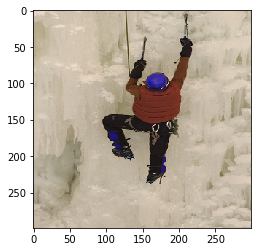

(1, 149, 149, 32)


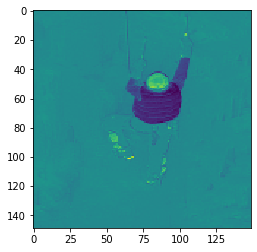

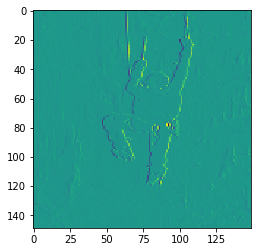

In [0]:
img = cv2.imread("Flicker8k_Dataset/102455176_5f8ead62d5.jpg")
img = cv2.resize(img, (299, 299))
plt.imshow(img)
plt.show()
img = np.expand_dims(img, axis=0)
model_conv_first = Model(model_encoder.input, model_encoder.layers[1].output)
conv_layer_out = model_conv_first.predict(img)
print(conv_layer_out.shape)
plt.imshow(conv_layer_out[0, :, :, 0])
plt.show()

plt.imshow(conv_layer_out[0, :, :, 20])
plt.show()

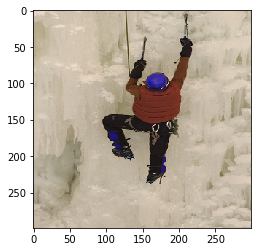

(1, 35, 35, 32)


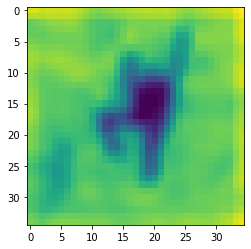

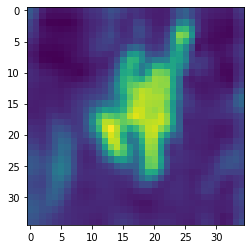

In [0]:
img = cv2.imread("Flicker8k_Dataset/102455176_5f8ead62d5.jpg")
img = cv2.resize(img, (299, 299))
plt.imshow(img)
plt.show()
img = np.expand_dims(img, axis=0)
model_conv_early = Model(model_encoder.input, model_encoder.layers[11].output)
conv_layer_out = model_conv.predict(img)
print(conv_layer_out.shape)
plt.imshow(conv_layer_out[0, :, :, 0])
plt.show()

plt.imshow(conv_layer_out[0, :, :, 20])
plt.show()

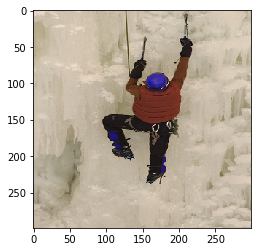

(1, 8, 8, 2048)


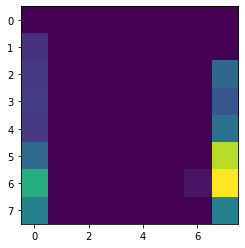

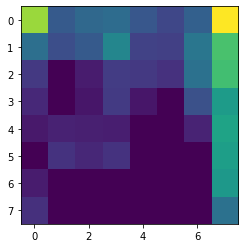

In [0]:
img = cv2.imread("Flicker8k_Dataset/102455176_5f8ead62d5.jpg")
img = cv2.resize(img, (299, 299))
plt.imshow(img)
plt.show()
img = np.expand_dims(img, axis=0)
model_conv_late = Model(model_encoder.input, model_encoder.layers[-2].output)
conv_layer_out = model_conv_late.predict(img)
print(conv_layer_out.shape)
plt.imshow(conv_layer_out[0, :, :, 50])
plt.show()

plt.imshow(conv_layer_out[0, :, :, 100])
plt.show()

For trainig the LSTM, we need the outputs from the second last layer (encodings) of our image classification model, InceptionV3. The below cell gets these outputs and stores them in a dictionary. This step takes a long time so we store the dictionary as a pickle file. I have dowloaded this pickle file and saved it in Google Drive. Do not run this cell.

In [0]:
image_dir = "Flicker8k_Dataset/"
img_paths = []
for i in os.listdir(image_dir):
    img_paths.append(image_dir+i)

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = (x/255. - 0.5)*2.
    return x

def encode(image):
    image = preprocess(image)
    temp_enc = model_encoder.predict(image)
    preds = np.reshape(temp_enc, temp_enc.shape[1])
    return preds

cnn_encodings = {}
for img_path in img_paths:
    cnn_encodings[img_path[len(image_dir):]] = encode(img_path)

with open("encoded_images_train.p", "wb") as encoded_pickle:
    pickle.dump(cnn_encodings, encoded_pickle)

This cell downloads the pickle file of the encodings from google drive and loads them in a dictionary.

In [0]:
downloaded = drive.CreateFile({'id':"1sFvhj6IcqQuiN1eiJfEjSrk7ZvO5VoWe"})
downloaded.GetContentFile('encoded_images.p')

cnn_encodings = pickle.load(open('encoded_images.p', 'rb'))

In the Flickr8k dataset, each image has 5 captions. This cell loads the capions in a dictionary with the image name as the key. The dictionary is of the form: `image_name: [c1, c2, c3, c4, c5]`

In [0]:
img_with_labels_file = 'Flickr8k.token.txt'
captions = open(img_with_labels_file, 'r').read().strip().split('\n')

img_captions_dict = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in img_captions_dict:
        img_captions_dict[row[0]].append(row[1])
    else:
        img_captions_dict[row[0]] = [row[1]]

The below 2 cells perform preprocessing on the captions. We remove all words with special characters, one letter words (namely, 'a') and add start and end tokens to the captions.

In [0]:
captions_processed = {}
for key, value in img_captions_dict.items():
    value_orig = value
    for i in range(len(value_orig)):
        value_orig[i] = text_to_word_sequence(value_orig[i], lower=True)
    captions_processed[key] = value_orig

In [0]:
for key, values in captions_processed.items():
    for i in range(len(values)):
        word_str = " ".join(values[i])
        caption = "<start> " + word_str + " <end>"
        captions_processed[key][i] = caption.replace(" a ", " ")

In [0]:
#printing the captions of an image.
captions_processed["1000268201_693b08cb0e.jpg"]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

The above cells have generated captions and encodings for all the images. However, we only need the training set. Thus, we read the file `Flick8k.trainImages.txt` to make dictionaries with only the training images.

In [0]:
f = open("Flickr_8k.trainImages.txt", "r")
filenames = f.read().split("\n")
f.close()

captions_processed_train = {}
cnn_encodings_train = {}

for filename in filenames[:-1]:
    captions_processed_train[filename] = captions_processed[filename]
    cnn_encodings_train[filename] = cnn_encodings[filename]

As machine learning models only deal with numbers, every word in our vocabulary is assigned a number. We also find out the total nunmber of words in the vocabulary. The `tf.keras.preprocessing.text.Tokenizer` class is used for this.

In [0]:
def create_tokenizer(captions):
    lines = captions.values()
    new_lines = []
    for i in lines:
        for j in i:
            new_lines.append(j)
    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(new_lines)
    return tokenizer

In [0]:
tokenizer = create_tokenizer(captions_processed_train)
global_vocab_size = len(tokenizer.word_index)+1
print(tokenizer.word_index)
print(global_vocab_size)

{'<start>': 1, '<end>': 2, 'in': 3, 'the': 4, 'on': 5, 'is': 6, 'and': 7, 'dog': 8, 'with': 9, 'man': 10, 'of': 11, 'two': 12, 'white': 13, 'black': 14, 'boy': 15, 'are': 16, 'woman': 17, 'girl': 18, 'to': 19, 'wearing': 20, 'at': 21, 'people': 22, 'water': 23, 'brown': 24, 'red': 25, 'young': 26, 'an': 27, 'his': 28, 'blue': 29, 'dogs': 30, 'running': 31, 'through': 32, 'shirt': 33, 'playing': 34, 'while': 35, 'down': 36, 'ball': 37, 'standing': 38, 'little': 39, 'grass': 40, 'snow': 41, 'child': 42, 'person': 43, 'jumping': 44, 'over': 45, 'three': 46, 'sitting': 47, 'field': 48, 'front': 49, 'holding': 50, 'small': 51, 'up': 52, 'green': 53, 'yellow': 54, 'group': 55, 'by': 56, 'large': 57, 'one': 58, 'walking': 59, 'her': 60, 'men': 61, 'children': 62, 'air': 63, 'into': 64, 'near': 65, 'mouth': 66, 'beach': 67, 'jumps': 68, 'runs': 69, 'another': 70, 'for': 71, 'street': 72, 'from': 73, 'its': 74, 'riding': 75, 'stands': 76, 'bike': 77, 'girls': 78, 'as': 79, 'outside': 80, 'play'

The below cell finds out the maximum length of a caption in our set.

In [0]:
def max_length(captions):
    captions_all = captions.values()
    captions_flattened = []
    for i in captions_all:
        for j in i:
            captions_flattened.append(j)

    return int(max(len(d.split()) for d in captions_flattened))

global_max_len = max_length(captions_processed_train)
print(global_max_len)

36


The LSTM predicts the sentence 1 word at a time. Given all the previous words in the sentence, the model is predicting the most probable word that comes next (target word). Thus, the LSTM model takes 2 inputs: the image encodings, and all the previous words in the sentence. We cannot pass all the data to the model in one go, as we will run out of memory. The solution? Data generators.

The bottom 2 cells define the data generator used to feed data to the model. They return the input and label in the form: `(encodings, words before), target word`. The main distinction between data generators and functions is that data generators remember their previous state, and so can output a different batch of data every time. This property makes them ideal for deep learning.

In [0]:
def create_partial_captions(captions, encoding, tokenizer, max_length, vocab_size):
    encodings = []
    partial_sequences = []
    target_words = []
    max_length = int(max_length)
    
    for caption in captions:
        sequence = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(sequence)):
            partial_seq = sequence[:i]
            partial_seq = pad_sequences([partial_seq], padding="post", maxlen=max_length)[0]

            target_seq = sequence[i]
            target_seq = to_categorical([target_seq], num_classes=vocab_size)[0]

            encodings.append(encoding)
            partial_sequences.append(partial_seq)
            target_words.append(target_seq)
    return encodings, partial_sequences, target_words

In [0]:
def data_generator(captions, encodings, tokenizer, max_length, vocab_size, num_images):
    in_imgs, in_seqs, out_words = np.array([]), np.array([]), np.array([])
    count = 0;
    while 1:
        for key, caption_list in captions.items():
            count += 1
            caption_list = captions[key]
            encoding = encodings[key]
            in_img, in_seq, out_word = create_partial_captions(caption_list, encoding, tokenizer, max_length, vocab_size)
            in_imgs = np.append(in_imgs, in_img)
            in_seqs = np.append(in_seqs, in_seq)
            out_words = np.append(out_words, out_word)
            if(count == num_images):
                in_imgs = in_imgs.reshape((int)(len(in_imgs)/2048), 2048)
                in_seqs = in_seqs.reshape((int)(len(in_seqs)/max_length), max_length)
                out_words = out_words.reshape((int)(len(out_words)/vocab_size), vocab_size)
                yield [[in_imgs, in_seqs], out_words]
                in_imgs, in_seqs, out_words = np.array([]), np.array([]), np.array([])
                count = 0;


Now, we define the model. There are 2 sub-models, which are then merged. One is the image model, which takes the image encodings as input and adds a dropout and dense layer next. The other sub-model is the caption model. It takes all the prior words in the sentence, and adds an Embedding, Dropout and an LSTM. These 2 models are then merged, and 2 dense layers are preformed on the merged models. The final layer has softmax activation and gives us the output.

In [0]:
#### .   SIMPLE MODEL
#####
#######
#########

global_embed_size = 300
# features from the CNN model squeezed from 2048 to 256 nodes
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(global_embed_size, activation='relu')(fe1)
# LSTM sequence model
inputs2 = Input(shape=(global_max_len,))
se1 = Embedding(global_vocab_size, global_embed_size, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(global_embed_size)(se2)
# Merging both models
decoder1 = add([fe2, se3])
decoder2 = Dense(global_embed_size, activation='relu')(decoder1)
outputs = Dense(global_vocab_size, activation='softmax')(decoder2)
# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=[outputs])
model.compile(loss='categorical_crossentropy', optimizer=Adam())
# summarize model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 36, 300)      2213100     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [0]:
#testing the data generator
[a,b],c = next(data_generator(captions_processed_train, cnn_encodings_train, tokenizer, global_max_len, global_vocab_size, num_images=2))
print(a.shape)
print(b.shape)
print(c.shape)

(95, 2048)
(95, 36)
(95, 7377)


We now define the number of epochs, and batch size for the model, and train it! After merley 6 epochs, a cross entropy loss of approximately 3.06 was achieved.

In [0]:
nb_train_samples = len(cnn_encodings_train)
nb_epochs = 10
batch_size = 100
#for i in range(nb_epochs):
#    generator = data_generator(captions_processed_train, cnn_encodings_train, tokenizer, global_max_len, global_vocab_size)
#    model.fit(generator, steps_per_epoch=steps, shuffle=True)

for i in range(nb_epochs):
    print("************** Epoch ", (i+1))
    data_gen = data_generator(captions_processed_train, cnn_encodings_train, tokenizer, global_max_len, global_vocab_size, num_images=batch_size)
    for j in range((int)(nb_train_samples/batch_size)):
        [a, b], c = next(data_gen)
        model.fit(x=[a, b], y=c)


************** Epoch  1
Train on 5305 samples
4896/5305 [==========================>...] - ETA: 0s - loss: 6.1115

KeyboardInterrupt: ignored

We save the model as a .h5 file for future use.

In [0]:
from tensorflow.keras.models import save_model
save_model(model, "simple_lstm.h5", include_optimizer=True, save_format="h5")

I had uploaded the saved model to Google Drive. The below cell loads the model from there.

In [0]:
#dowloading metadata and images
downloaded = drive.CreateFile({'id':"17jUM8u1OF7LxS7iGntHdX0KDFbcfoTy1"})
downloaded.GetContentFile('simple_lstm.h5')

from tensorflow.keras.models import load_model
model = load_model("simple_lstm.h5")

Now, we generate the test data, used to evaluate our model.

In [0]:
 f = open("Flickr_8k.testImages.txt", "r")
filenames = f.read().split("\n")
f.close()

captions_processed_test = {}
cnn_encodings_test = {}

for filename in filenames[:-1]:
    captions_processed_test[filename] = captions_processed[filename]
    cnn_encodings_test[filename] = cnn_encodings[filename]

In [0]:
#function to call tokeniser
def id_to_word(integer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

To optimize caption generation further, rather than just take the most probable sentence, we run beam search, which considers the top 'k' sentences, in our case, 5.

In [0]:
def beam_search_k(image_file, beam_index=5):
    start_word_id = [tokenizer.word_index["<start>"]]
    end_word_id = [tokenizer.word_index["<end>"]]
    continue_search = True
    
    # sentences[0][0] is the first sentence
    # sentences[0][1] is the probability of the first sentence
    # we start with just one sentence that has only <start> word with probability 1.0
    sentences = [[start_word_id, 1.0]]
    

    while continue_search:
        temp = []
        for sentence in sentences:
            if(sentence[0][-1] == end_word_id):
                continue
            padded_caption = pad_sequences([sentence[0]], maxlen=global_max_len, padding='post')
            encoding = cnn_encodings[image_file]
            # we will get the entire vocabulary with probability of each word
            preds = model.predict([np.array([encoding]), np.array(padded_caption)])[0]
            
            # Getting the top <beam_index>(n) predictions
            top_words = np.argsort(preds)[-beam_index:]
            
            # create a new list so as to put them via the model again
            for word in top_words:
                next_cap, prob = sentence[0][:], sentence[1]
                next_cap.append(word)
                prob *= preds[word]
                temp.append([next_cap, prob])
                    
        sentences = temp
        # Sorting according to the probabilities
        sentences = sorted(sentences, reverse=False, key=lambda l: l[1])
        # Getting the top <beam_index>(n) sentences
        sentences = sentences[-beam_index:]
        count = 0
        for sentence in sentences:
            if sentence[0][-1] == end_word_id or len(sentence[0]) == global_max_len:
                count += 1

        if(count == beam_index):
            continue_search = False
    
    final_out = ""
    for nb_output in range(1, 4):
        start_word = sentences[-nb_output][0]
        prob = sentences[-nb_output][1]
        intermediate_caption = [id_to_word(i) for i in start_word]

        final_caption = []

        for i in intermediate_caption:
            if i != '<end>':
                final_caption.append(i)
            else:
                break
        final_out += ' '.join(final_caption[1:]) + "(prob: " + str(prob) + ")\n"

    return final_out

Finally, the moment we've been waiting for! We use PIL to display some test images, and call the model to generate captions. We run beam search on these captions to get the final output.

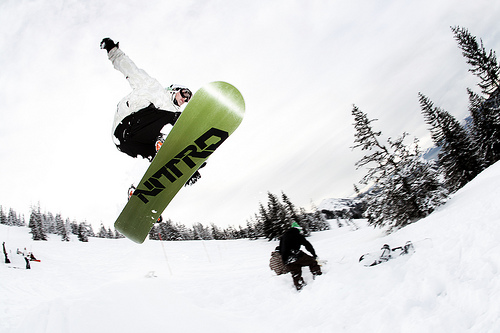

two people are climbing up snowy mountain(prob: 0.00021415329233391133)
two people are skiing down snowy hill(prob: 0.000183435301717912)
two people are skiing down snowy mountain(prob: 0.00015097552782830008)



In [0]:
img_name="3108732084_565b423162.jpg"
display(Image('Flicker8k_Dataset/' + img_name))
captions = beam_search_k(img_name, beam_index=5)
print(captions)

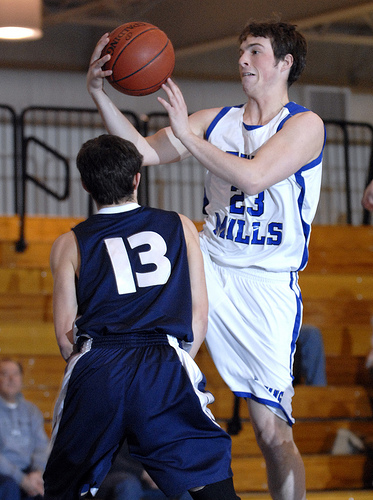

basketball player in red uniform is ready to tackle ball
basketball player in red uniform is ready to tackle ball
basketball player in red uniform is ready to tackle ball



In [0]:
img_name = "3259666643_ae49524c81.jpg"
display(Image("Flicker8k_Dataset/" + img_name))
captions = beam_search(img_name, beam_index=5)
print(captions)

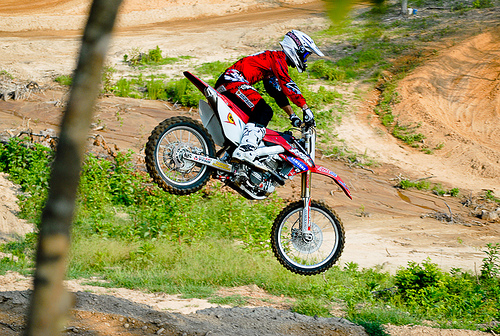

man in red shirt is riding bike on dirt road
man in red shirt is riding bike on dirt road
man in red shirt is riding bike on dirt road



In [0]:
img_name = "3670907052_c827593564.jpg"
display(Image("Flicker8k_Dataset/" + img_name))
captions = beam_search(img_name, beam_index=5)
print(captions)